<a href="https://colab.research.google.com/github/gabrieldimas/periapical-photo-caries-detection-using-deep-learning/blob/main/testing_model_with_kaggle_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -q ultralytics
!pip install -q opencv-python
!pip install -q Pillow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 27.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 104.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 85.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 50.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 32.7 MB/s eta 0:00:00


In [2]:
import os
import torch
import cv2
import numpy as np
from PIL import Image
from ultralytics import YOLO
import matplotlib.pyplot as plt
import zipfile
import glob
from google.colab import files

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [3]:
object_model_path = "/content/object.pt"
classification_model_path = "/content/classification2.pt"

In [4]:
print("Memuat model deteksi objek...")
detector = YOLO(object_model_path)  # Model untuk deteksi gigi

print("Memuat model klasifikasi...")
classifier = YOLO(classification_model_path)  # Model untuk klasifikasi jenis karies

Memuat model deteksi objek...
Memuat model klasifikasi...


In [5]:
test_folder = '/content/test_data'
os.makedirs(test_folder, exist_ok=True)

In [6]:
def visualize_results(image, detections, classifications, conf_threshold=0.25):
    img = image.copy()

    class_colors = {
        'noncaries': (0, 255, 0),  # Hijau
        'caries_superficial': (0, 255, 255),  # Kuning
        'caries_media': (0, 165, 255),  # Oranye
        'caries_profunda': (0, 0, 255)  # Merah
    }

    # Gambar kotak dan label untuk setiap deteksi
    detected_teeth = []
    for detection in detections:
        boxes = detection.boxes
        for box_idx in range(len(boxes)):
            if boxes[box_idx].conf.item() < conf_threshold:
                continue

            box = boxes[box_idx].xyxy.cpu().numpy().astype(int)[0]
            detected_teeth.append((box, boxes[box_idx].conf.item()))

    # Gambar hasil deteksi dan klasifikasi
    for i, ((x1, y1, x2, y2), conf) in enumerate(detected_teeth):
        # Klasifikasi jenis karies jika tersedia
        if i < len(classifications):
            class_name, class_conf = classifications[i]
            color = class_colors.get(class_name, (255, 255, 255))

            # Format label: class_name (confidence)
            label = f"{class_name} ({class_conf:.2f})"
        else:
            color = (255, 255, 255)  # Putih jika tidak ada klasifikasi
            label = f"Gigi ({conf:.2f})"

        # Gambar kotak pembatas
        cv2.rectangle(img, (x1, y1), (x2, y2), color, 2)

        # Tambahkan label
        text_width = len(label) * 10
        cv2.rectangle(img, (x1, y1 - 20), (x1 + text_width, y1), color, -1)
        cv2.putText(img, label, (x1, y1 - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 0), 1)

    return img

In [7]:
def resize_image(image, target_size=(640, 640)):
    # Gunakan cv2.resize dengan interpolasi yang sesuai
    resized = cv2.resize(image, target_size, interpolation=cv2.INTER_AREA)
    return resized

In [8]:
def apply_clahe(image):
    # Konversi ke LAB color space (L untuk luminance)
    lab = cv2.cvtColor(image, cv2.COLOR_RGB2LAB)

    # Pisahkan channel
    l, a, b = cv2.split(lab)

    # Buat CLAHE object
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))

    # Terapkan CLAHE pada channel L
    clahe_l = clahe.apply(l)

    # Gabungkan kembali channel
    enhanced_lab = cv2.merge((clahe_l, a, b))

    # Konversi kembali ke RGB
    enhanced_rgb = cv2.cvtColor(enhanced_lab, cv2.COLOR_LAB2RGB)

    return enhanced_rgb

In [9]:
def detect_and_classify_teeth(image_path, detector, classifier, conf_threshold=0.25):
    # Baca gambar
    img = cv2.imread(image_path)
    if img is None:
        print(f"Error: Tidak dapat membaca gambar {image_path}")
        return None, [], []

    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Step 1: Resize gambar ke 640x640
    print("Melakukan resize gambar ke 640x640 pixels...")
    img_resized = resize_image(img_rgb, target_size=(640, 640))

    # Step 2: Deteksi gigi pada gambar yang sudah diresize
    print("Mendeteksi gigi...")
    detection_results = detector(img_resized)

    # Menyimpan hasil klasifikasi untuk tiap gigi yang terdeteksi
    classifications = []
    detected_teeth = []

    # Untuk setiap gigi yang terdeteksi, lakukan klasifikasi
    for detection in detection_results:
        boxes = detection.boxes
        for box_idx in range(len(boxes)):
            if boxes[box_idx].conf.item() < conf_threshold:
                continue

            box = boxes[box_idx].xyxy.cpu().numpy().astype(int)[0]
            detected_teeth.append((box, boxes[box_idx].conf.item()))

            x1, y1, x2, y2 = box

            # Crop area gigi yang terdeteksi
            tooth_img = img_resized[y1:y2, x1:x2]

            if tooth_img.size == 0:  # Jika crop gagal (box terlalu kecil)
                classifications.append(('unknown', 0.0))
                continue

            # Step 3: Terapkan CLAHE pada area gigi yang terdeteksi
            print(f"Menerapkan CLAHE pada gigi #{len(detected_teeth)}...")
            tooth_enhanced = apply_clahe(tooth_img)

            # Konversi ke PIL Image
            tooth_pil = Image.fromarray(tooth_enhanced)

            # Step 4: Klasifikasi jenis karies pada gambar yang telah ditingkatkan
            print(f"Melakukan klasifikasi pada gigi #{len(detected_teeth)}...")
            class_result = classifier(tooth_pil)[0]

            # Ambil hasil klasifikasi dengan confidence tertinggi
            class_index = class_result.probs.top1
            class_conf = class_result.probs.top1conf.item()
            class_name = class_result.names[class_index]

            classifications.append((class_name, class_conf))

    # Visualisasi hasil
    result_img = visualize_results(img_resized, detection_results, classifications, conf_threshold)

    # Tampilkan juga gambar original yang diresize untuk perbandingan
    return result_img, detected_teeth, classifications, img_resized

In [10]:
def process_test_images(image_paths, detector, classifier, conf_threshold=0.25):
    # Metrik evaluasi
    total_teeth_detected = 0
    class_distribution = {
        'noncaries': 0,
        'caries_superficial': 0,
        'caries_media': 0,
        'caries_profunda': 0,
        'unknown': 0
    }
    for i, image_path in enumerate(image_paths):
        print(f"\nMemproses gambar {i+1}/{len(image_paths)}: {os.path.basename(image_path)}")

        # Deteksi dan klasifikasi
        result_img, detected_teeth, classifications, resized_img = detect_and_classify_teeth(
            image_path, detector, classifier, conf_threshold
        )

        if result_img is None:
            continue

        # Update metrik
        num_teeth = len(detected_teeth)
        total_teeth_detected += num_teeth

        for class_name, _ in classifications:
            if class_name in class_distribution:
                class_distribution[class_name] += 1
            else:
                class_distribution['unknown'] += 1

        # Tampilkan gambar asli yang sudah diresize
        plt.figure(figsize=(15, 6))
        plt.subplot(1, 2, 1)
        plt.imshow(resized_img)
        plt.axis('off')
        plt.title('Gambar Original (640x640)')

        # Tampilkan hasil deteksi dan klasifikasi
        plt.subplot(1, 2, 2)
        plt.imshow(result_img)
        plt.axis('off')
        plt.title(f'Hasil Deteksi & Klasifikasi ({num_teeth} gigi)')
        plt.tight_layout()
        plt.show()

        # Tampilkan hasil dalam bentuk teks
        print(f"  - Jumlah gigi terdeteksi: {num_teeth}")
        for j, ((box, conf), (class_name, class_conf)) in enumerate(zip(detected_teeth, classifications)):
            print(f"  - Gigi #{j+1} - Confidence: {conf:.2f}, Klasifikasi: {class_name} ({class_conf:.2f})")
    if total_teeth_detected > 0:
        print("\n=== RINGKASAN HASIL ===")
        print(f"Total gambar yang diproses: {len(image_paths)}")
        print(f"Total gigi terdeteksi: {total_teeth_detected}")
        print("Distribusi klasifikasi:")
        for class_name, count in class_distribution.items():
            if count > 0:
                print(f"  - {class_name}: {count} ({count/total_teeth_detected*100:.1f}%)")
    else:
        print("\nTidak ada gigi yang terdeteksi dalam dataset.")

OPSI 1: Upload gambar test secara langsung
Silakan upload gambar test (bisa multiple files):


Saving Primary Endo with Secondary Perio (19).JPG to Primary Endo with Secondary Perio (19).JPG
Saving Primary Endo with Secondary Perio (32).JPG to Primary Endo with Secondary Perio (32).JPG
Saving Primary Endo with Secondary Perio (45).JPG to Primary Endo with Secondary Perio (45).JPG
Saving Primary Endo with Secondary Perio (58).JPG to Primary Endo with Secondary Perio (58).JPG
Saving Primary Endo with Secondary Perio (74).JPG to Primary Endo with Secondary Perio (74).JPG
Saving Primary Endo with Secondary Perio (76).JPG to Primary Endo with Secondary Perio (76).JPG
Saving Primary Endo with Secondary Perio (98).JPG to Primary Endo with Secondary Perio (98).JPG
Saving Primary Endo with Secondary Perio (99).JPG to Primary Endo with Secondary Perio (99).JPG
Saving Primary Endodontic  Lesion (21).JPG to Primary Endodontic  Lesion (21).JPG
Saving Primary Endodontic  Lesion (37).JPG to Primary Endodontic  Lesion (37).JPG
Saving Primary Endodontic  Lesion (41).JPG to Primary Endodontic  Le

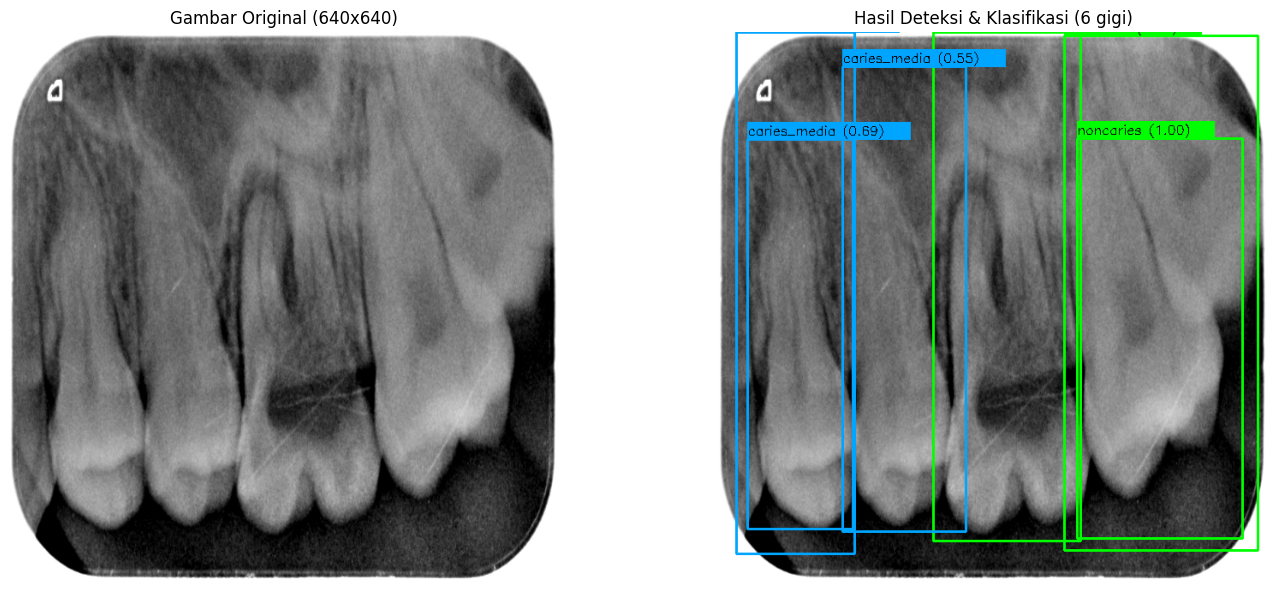

  - Jumlah gigi terdeteksi: 6
  - Gigi #1 - Confidence: 0.74, Klasifikasi: noncaries (1.00)
  - Gigi #2 - Confidence: 0.67, Klasifikasi: noncaries (0.81)
  - Gigi #3 - Confidence: 0.55, Klasifikasi: caries_media (0.58)
  - Gigi #4 - Confidence: 0.52, Klasifikasi: caries_media (0.55)
  - Gigi #5 - Confidence: 0.36, Klasifikasi: noncaries (1.00)
  - Gigi #6 - Confidence: 0.34, Klasifikasi: caries_media (0.69)

Memproses gambar 2/21: Primary Endo with Secondary Perio (32).JPG
Melakukan resize gambar ke 640x640 pixels...
Mendeteksi gigi...

0: 640x640 5 tooths, 261.2ms
Speed: 4.0ms preprocess, 261.2ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)
Menerapkan CLAHE pada gigi #1...
Melakukan klasifikasi pada gigi #1...

0: 640x640 noncaries 0.85, caries_media 0.14, caries_profunda 0.00, caries_superficial 0.00, 103.8ms
Speed: 27.6ms preprocess, 103.8ms inference, 0.1ms postprocess per image at shape (1, 3, 640, 640)
Menerapkan CLAHE pada gigi #2...
Melakukan klasifikasi pad

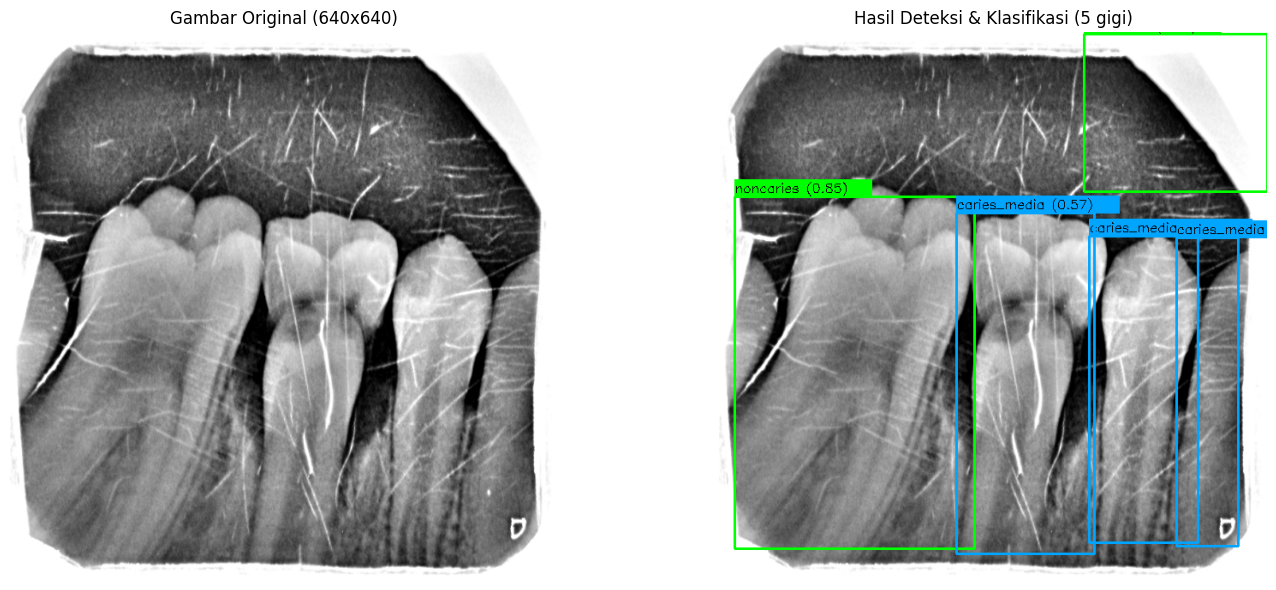

  - Jumlah gigi terdeteksi: 5
  - Gigi #1 - Confidence: 0.77, Klasifikasi: noncaries (0.85)
  - Gigi #2 - Confidence: 0.64, Klasifikasi: caries_media (1.00)
  - Gigi #3 - Confidence: 0.39, Klasifikasi: noncaries (0.97)
  - Gigi #4 - Confidence: 0.39, Klasifikasi: caries_media (1.00)
  - Gigi #5 - Confidence: 0.36, Klasifikasi: caries_media (0.57)

Memproses gambar 3/21: Primary Endo with Secondary Perio (45).JPG
Melakukan resize gambar ke 640x640 pixels...
Mendeteksi gigi...

0: 640x640 3 tooths, 236.3ms
Speed: 9.7ms preprocess, 236.3ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)
Menerapkan CLAHE pada gigi #1...
Melakukan klasifikasi pada gigi #1...

0: 640x640 noncaries 1.00, caries_superficial 0.00, caries_profunda 0.00, caries_media 0.00, 88.6ms
Speed: 30.3ms preprocess, 88.6ms inference, 0.1ms postprocess per image at shape (1, 3, 640, 640)
Menerapkan CLAHE pada gigi #2...
Melakukan klasifikasi pada gigi #2...

0: 640x640 noncaries 1.00, caries_superficial 0.00

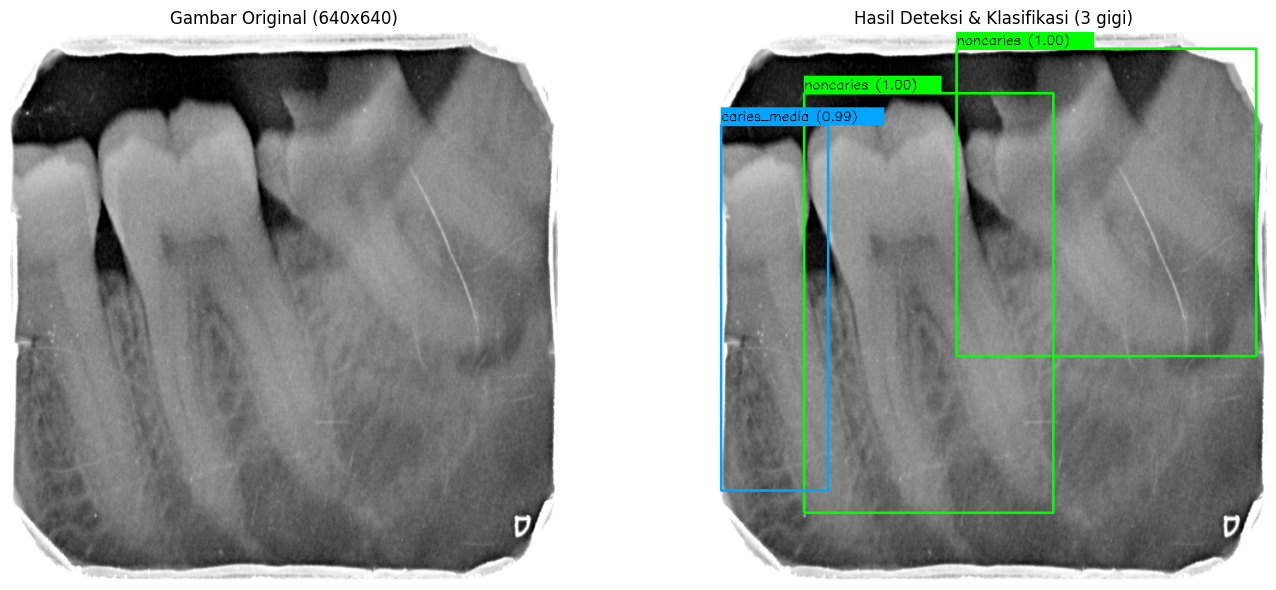

  - Jumlah gigi terdeteksi: 3
  - Gigi #1 - Confidence: 0.68, Klasifikasi: noncaries (1.00)
  - Gigi #2 - Confidence: 0.68, Klasifikasi: noncaries (1.00)
  - Gigi #3 - Confidence: 0.26, Klasifikasi: caries_media (0.99)

Memproses gambar 4/21: Primary Endo with Secondary Perio (58).JPG
Melakukan resize gambar ke 640x640 pixels...
Mendeteksi gigi...

0: 640x640 1 tooth, 259.7ms
Speed: 3.7ms preprocess, 259.7ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)
Menerapkan CLAHE pada gigi #1...
Melakukan klasifikasi pada gigi #1...

0: 640x640 caries_media 0.67, caries_profunda 0.24, noncaries 0.09, caries_superficial 0.00, 96.7ms
Speed: 44.8ms preprocess, 96.7ms inference, 0.1ms postprocess per image at shape (1, 3, 640, 640)


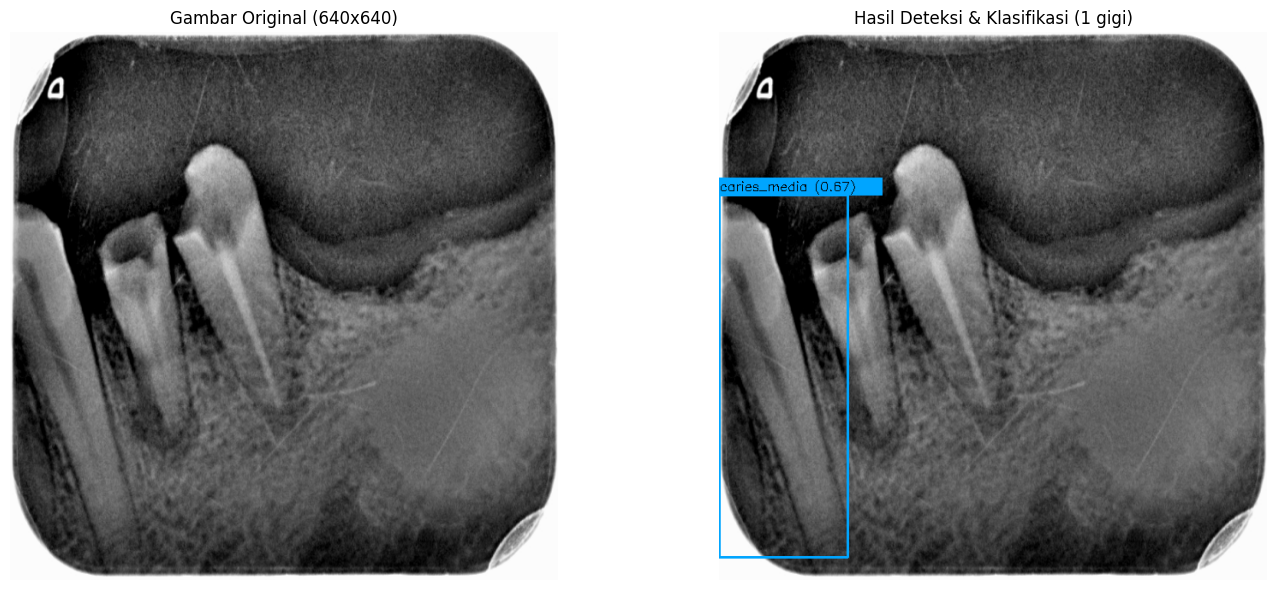

  - Jumlah gigi terdeteksi: 1
  - Gigi #1 - Confidence: 0.42, Klasifikasi: caries_media (0.67)

Memproses gambar 5/21: Primary Endo with Secondary Perio (74).JPG
Melakukan resize gambar ke 640x640 pixels...
Mendeteksi gigi...

0: 640x640 4 tooths, 245.0ms
Speed: 6.5ms preprocess, 245.0ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)
Menerapkan CLAHE pada gigi #1...
Melakukan klasifikasi pada gigi #1...

0: 640x640 noncaries 0.76, caries_media 0.22, caries_profunda 0.03, caries_superficial 0.00, 97.4ms
Speed: 31.3ms preprocess, 97.4ms inference, 0.1ms postprocess per image at shape (1, 3, 640, 640)
Menerapkan CLAHE pada gigi #2...
Melakukan klasifikasi pada gigi #2...

0: 640x640 noncaries 1.00, caries_profunda 0.00, caries_media 0.00, caries_superficial 0.00, 94.1ms
Speed: 25.8ms preprocess, 94.1ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)
Menerapkan CLAHE pada gigi #3...
Melakukan klasifikasi pada gigi #3...

0: 640x640 noncaries 0.51, caries_

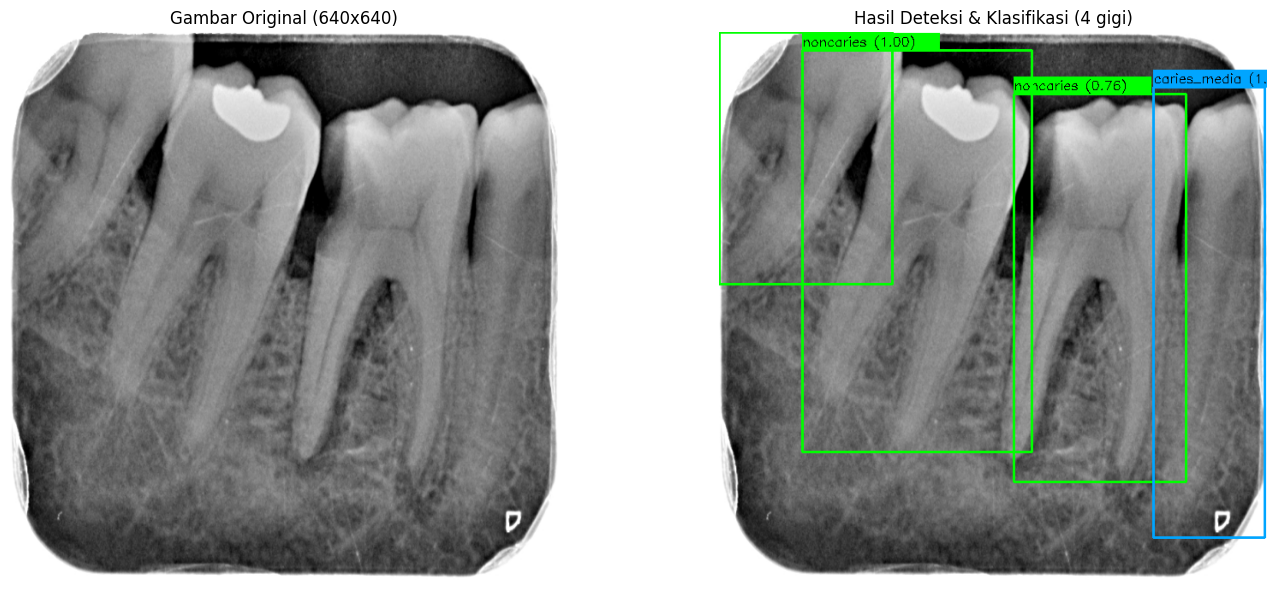

  - Jumlah gigi terdeteksi: 4
  - Gigi #1 - Confidence: 0.77, Klasifikasi: noncaries (0.76)
  - Gigi #2 - Confidence: 0.70, Klasifikasi: noncaries (1.00)
  - Gigi #3 - Confidence: 0.45, Klasifikasi: noncaries (0.51)
  - Gigi #4 - Confidence: 0.36, Klasifikasi: caries_media (1.00)

Memproses gambar 6/21: Primary Endo with Secondary Perio (76).JPG
Melakukan resize gambar ke 640x640 pixels...
Mendeteksi gigi...

0: 640x640 2 tooths, 246.7ms
Speed: 6.7ms preprocess, 246.7ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)
Menerapkan CLAHE pada gigi #1...
Melakukan klasifikasi pada gigi #1...

0: 640x640 noncaries 0.47, caries_media 0.44, caries_profunda 0.09, caries_superficial 0.00, 121.1ms
Speed: 26.9ms preprocess, 121.1ms inference, 0.1ms postprocess per image at shape (1, 3, 640, 640)
Menerapkan CLAHE pada gigi #2...
Melakukan klasifikasi pada gigi #2...

0: 640x640 caries_media 1.00, noncaries 0.00, caries_superficial 0.00, caries_profunda 0.00, 123.5ms
Speed: 56.3ms p

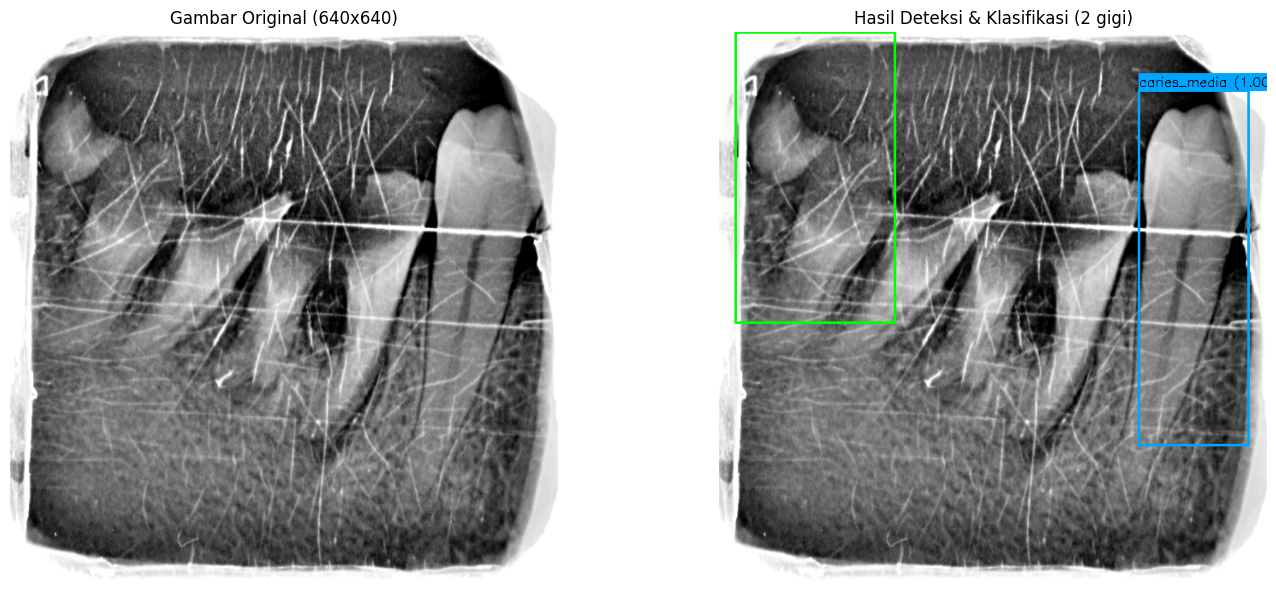

  - Jumlah gigi terdeteksi: 2
  - Gigi #1 - Confidence: 0.41, Klasifikasi: noncaries (0.47)
  - Gigi #2 - Confidence: 0.31, Klasifikasi: caries_media (1.00)

Memproses gambar 7/21: Primary Endo with Secondary Perio (98).JPG
Melakukan resize gambar ke 640x640 pixels...
Mendeteksi gigi...

0: 640x640 4 tooths, 250.5ms
Speed: 9.2ms preprocess, 250.5ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)
Menerapkan CLAHE pada gigi #1...
Melakukan klasifikasi pada gigi #1...

0: 640x640 noncaries 0.99, caries_profunda 0.01, caries_media 0.00, caries_superficial 0.00, 107.8ms
Speed: 29.9ms preprocess, 107.8ms inference, 0.1ms postprocess per image at shape (1, 3, 640, 640)
Menerapkan CLAHE pada gigi #2...
Melakukan klasifikasi pada gigi #2...

0: 640x640 caries_media 0.96, caries_profunda 0.03, noncaries 0.01, caries_superficial 0.00, 105.5ms
Speed: 33.3ms preprocess, 105.5ms inference, 0.1ms postprocess per image at shape (1, 3, 640, 640)
Menerapkan CLAHE pada gigi #3...
Melakuk

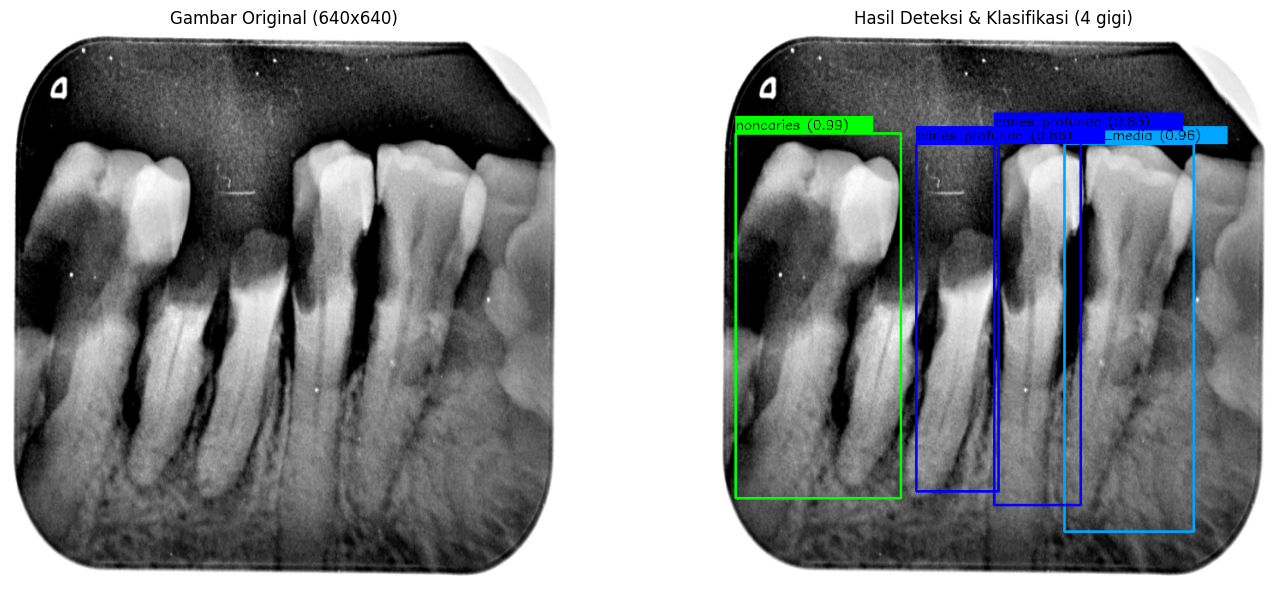

  - Jumlah gigi terdeteksi: 4
  - Gigi #1 - Confidence: 0.77, Klasifikasi: noncaries (0.99)
  - Gigi #2 - Confidence: 0.68, Klasifikasi: caries_media (0.96)
  - Gigi #3 - Confidence: 0.47, Klasifikasi: caries_profunda (0.86)
  - Gigi #4 - Confidence: 0.47, Klasifikasi: caries_profunda (0.83)

Memproses gambar 8/21: Primary Endo with Secondary Perio (99).JPG
Melakukan resize gambar ke 640x640 pixels...
Mendeteksi gigi...

0: 640x640 4 tooths, 252.6ms
Speed: 3.9ms preprocess, 252.6ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)
Menerapkan CLAHE pada gigi #1...
Melakukan klasifikasi pada gigi #1...

0: 640x640 noncaries 1.00, caries_profunda 0.00, caries_superficial 0.00, caries_media 0.00, 109.9ms
Speed: 29.5ms preprocess, 109.9ms inference, 0.1ms postprocess per image at shape (1, 3, 640, 640)
Menerapkan CLAHE pada gigi #2...
Melakukan klasifikasi pada gigi #2...

0: 640x640 noncaries 0.85, caries_media 0.08, caries_profunda 0.07, caries_superficial 0.00, 121.2ms
Spe

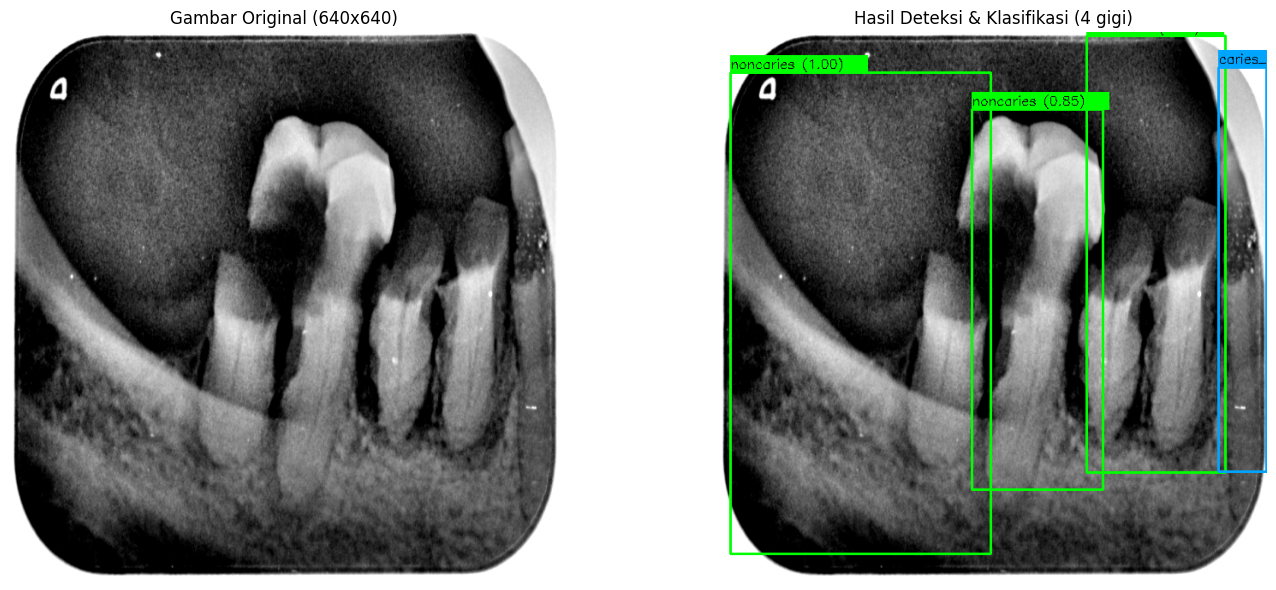

  - Jumlah gigi terdeteksi: 4
  - Gigi #1 - Confidence: 0.60, Klasifikasi: noncaries (1.00)
  - Gigi #2 - Confidence: 0.45, Klasifikasi: noncaries (0.85)
  - Gigi #3 - Confidence: 0.31, Klasifikasi: noncaries (0.98)
  - Gigi #4 - Confidence: 0.29, Klasifikasi: caries_media (0.71)

Memproses gambar 9/21: Primary Endodontic  Lesion (21).JPG
Melakukan resize gambar ke 640x640 pixels...
Mendeteksi gigi...

0: 640x640 4 tooths, 246.9ms
Speed: 3.8ms preprocess, 246.9ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)
Menerapkan CLAHE pada gigi #1...
Melakukan klasifikasi pada gigi #1...

0: 640x640 caries_media 1.00, noncaries 0.00, caries_profunda 0.00, caries_superficial 0.00, 116.0ms
Speed: 24.1ms preprocess, 116.0ms inference, 0.1ms postprocess per image at shape (1, 3, 640, 640)
Menerapkan CLAHE pada gigi #2...
Melakukan klasifikasi pada gigi #2...

0: 640x640 noncaries 0.95, caries_profunda 0.05, caries_superficial 0.00, caries_media 0.00, 124.8ms
Speed: 36.1ms preproce

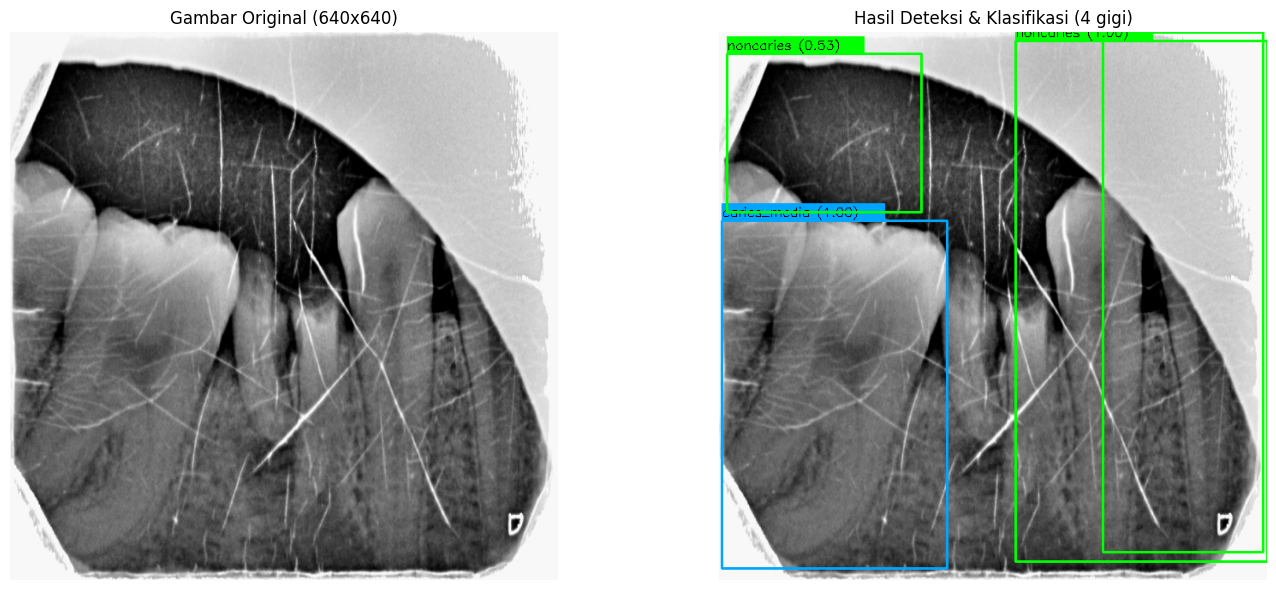

  - Jumlah gigi terdeteksi: 4
  - Gigi #1 - Confidence: 0.80, Klasifikasi: caries_media (1.00)
  - Gigi #2 - Confidence: 0.34, Klasifikasi: noncaries (0.95)
  - Gigi #3 - Confidence: 0.33, Klasifikasi: noncaries (1.00)
  - Gigi #4 - Confidence: 0.33, Klasifikasi: noncaries (0.53)

Memproses gambar 10/21: Primary Endodontic  Lesion (37).JPG
Melakukan resize gambar ke 640x640 pixels...
Mendeteksi gigi...

0: 640x640 5 tooths, 330.8ms
Speed: 3.9ms preprocess, 330.8ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)
Menerapkan CLAHE pada gigi #1...
Melakukan klasifikasi pada gigi #1...

0: 640x640 caries_media 0.99, caries_profunda 0.00, noncaries 0.00, caries_superficial 0.00, 158.8ms
Speed: 34.7ms preprocess, 158.8ms inference, 0.1ms postprocess per image at shape (1, 3, 640, 640)
Menerapkan CLAHE pada gigi #2...
Melakukan klasifikasi pada gigi #2...

0: 640x640 caries_media 0.69, noncaries 0.20, caries_profunda 0.11, caries_superficial 0.00, 131.4ms
Speed: 49.7ms preproc

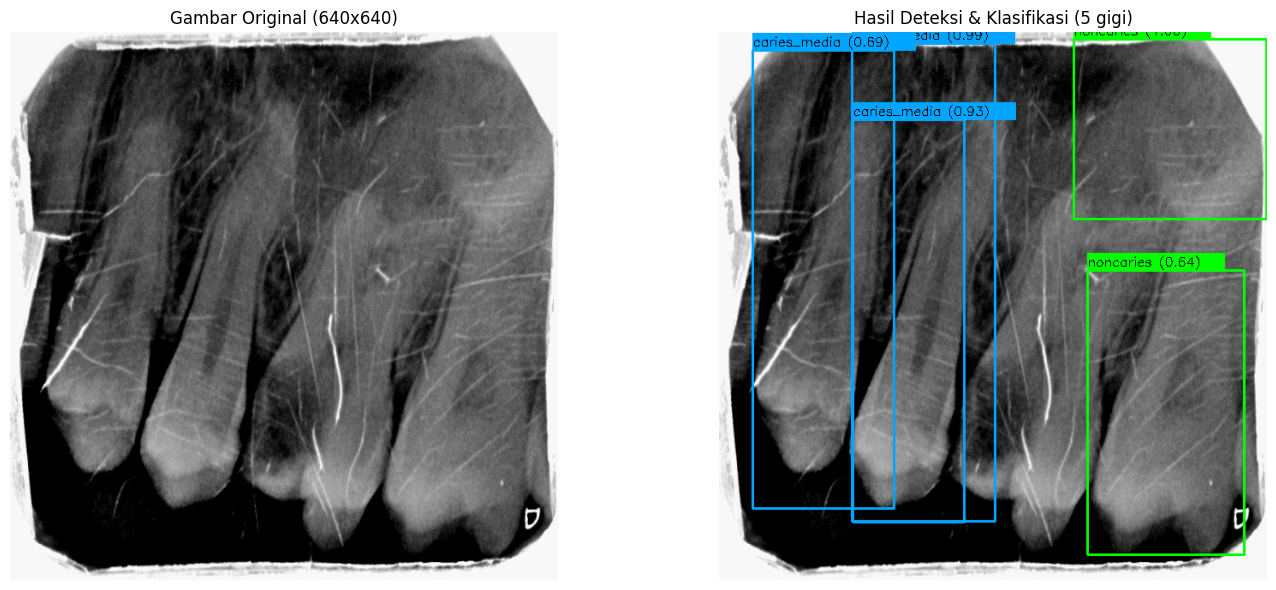

  - Jumlah gigi terdeteksi: 5
  - Gigi #1 - Confidence: 0.63, Klasifikasi: caries_media (0.99)
  - Gigi #2 - Confidence: 0.58, Klasifikasi: caries_media (0.69)
  - Gigi #3 - Confidence: 0.56, Klasifikasi: noncaries (0.64)
  - Gigi #4 - Confidence: 0.40, Klasifikasi: noncaries (1.00)
  - Gigi #5 - Confidence: 0.37, Klasifikasi: caries_media (0.93)

Memproses gambar 11/21: Primary Endodontic  Lesion (41).JPG
Melakukan resize gambar ke 640x640 pixels...
Mendeteksi gigi...

0: 640x640 3 tooths, 286.7ms
Speed: 3.9ms preprocess, 286.7ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)
Menerapkan CLAHE pada gigi #1...
Melakukan klasifikasi pada gigi #1...

0: 640x640 caries_media 1.00, noncaries 0.00, caries_profunda 0.00, caries_superficial 0.00, 124.9ms
Speed: 26.3ms preprocess, 124.9ms inference, 0.1ms postprocess per image at shape (1, 3, 640, 640)
Menerapkan CLAHE pada gigi #2...
Melakukan klasifikasi pada gigi #2...

0: 640x640 caries_media 1.00, noncaries 0.00, caries_p

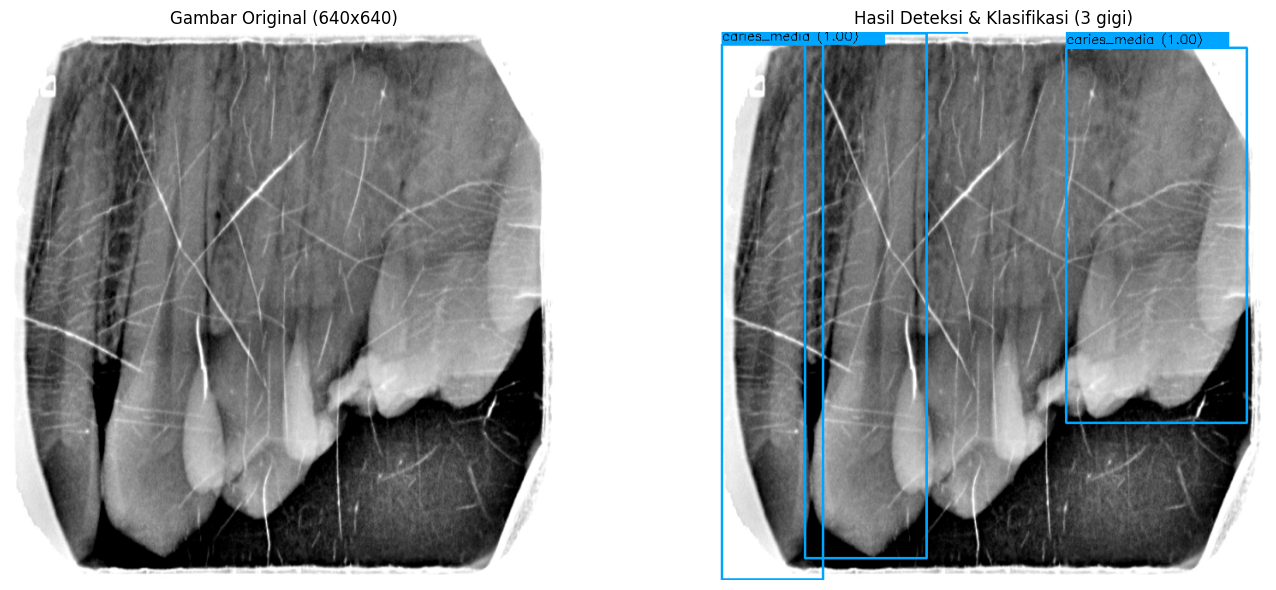

  - Jumlah gigi terdeteksi: 3
  - Gigi #1 - Confidence: 0.62, Klasifikasi: caries_media (1.00)
  - Gigi #2 - Confidence: 0.60, Klasifikasi: caries_media (1.00)
  - Gigi #3 - Confidence: 0.49, Klasifikasi: caries_media (1.00)

Memproses gambar 12/21: Primary Endodontic Lesion (8).JPG
Melakukan resize gambar ke 640x640 pixels...
Mendeteksi gigi...

0: 640x640 4 tooths, 351.8ms
Speed: 4.0ms preprocess, 351.8ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)
Menerapkan CLAHE pada gigi #1...
Melakukan klasifikasi pada gigi #1...

0: 640x640 noncaries 0.91, caries_media 0.09, caries_profunda 0.00, caries_superficial 0.00, 148.4ms
Speed: 32.9ms preprocess, 148.4ms inference, 0.1ms postprocess per image at shape (1, 3, 640, 640)
Menerapkan CLAHE pada gigi #2...
Melakukan klasifikasi pada gigi #2...

0: 640x640 noncaries 0.71, caries_profunda 0.29, caries_superficial 0.00, caries_media 0.00, 141.1ms
Speed: 43.6ms preprocess, 141.1ms inference, 0.1ms postprocess per image at sha

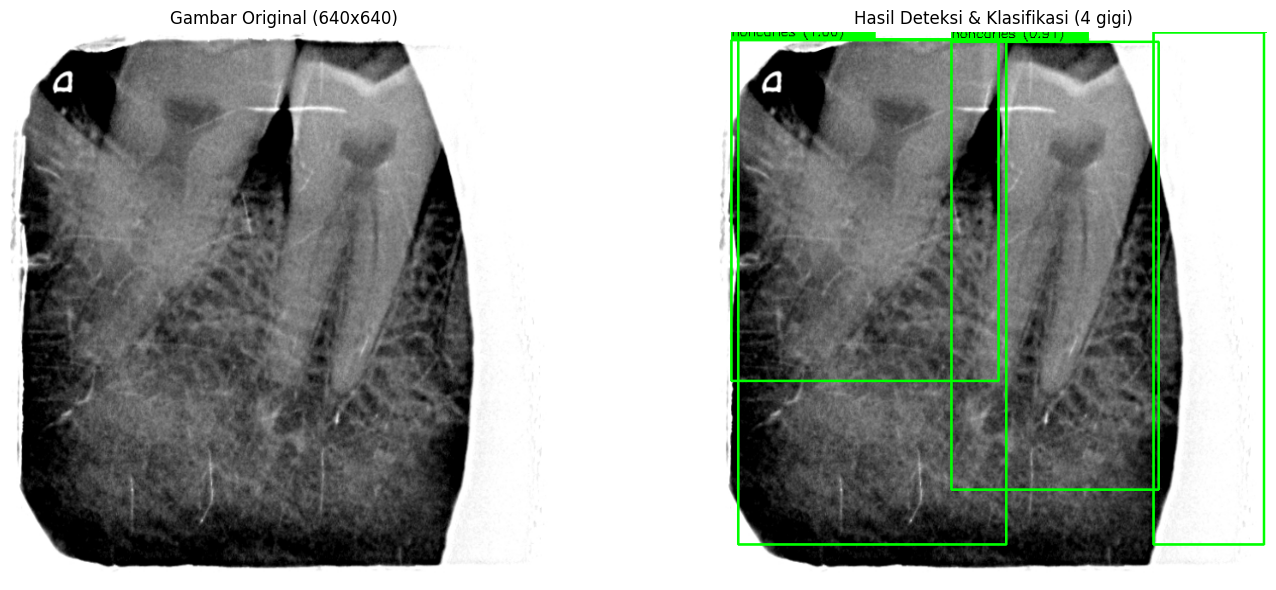

  - Jumlah gigi terdeteksi: 4
  - Gigi #1 - Confidence: 0.68, Klasifikasi: noncaries (0.91)
  - Gigi #2 - Confidence: 0.65, Klasifikasi: noncaries (0.71)
  - Gigi #3 - Confidence: 0.54, Klasifikasi: noncaries (0.99)
  - Gigi #4 - Confidence: 0.36, Klasifikasi: noncaries (1.00)

Memproses gambar 13/21: Primary Endodontic Lesion (10).JPG
Melakukan resize gambar ke 640x640 pixels...
Mendeteksi gigi...

0: 640x640 3 tooths, 269.6ms
Speed: 3.6ms preprocess, 269.6ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)
Menerapkan CLAHE pada gigi #1...
Melakukan klasifikasi pada gigi #1...

0: 640x640 noncaries 1.00, caries_superficial 0.00, caries_profunda 0.00, caries_media 0.00, 123.6ms
Speed: 24.5ms preprocess, 123.6ms inference, 0.1ms postprocess per image at shape (1, 3, 640, 640)
Menerapkan CLAHE pada gigi #2...
Melakukan klasifikasi pada gigi #2...

0: 640x640 noncaries 1.00, caries_superficial 0.00, caries_profunda 0.00, caries_media 0.00, 124.0ms
Speed: 20.9ms preprocess,

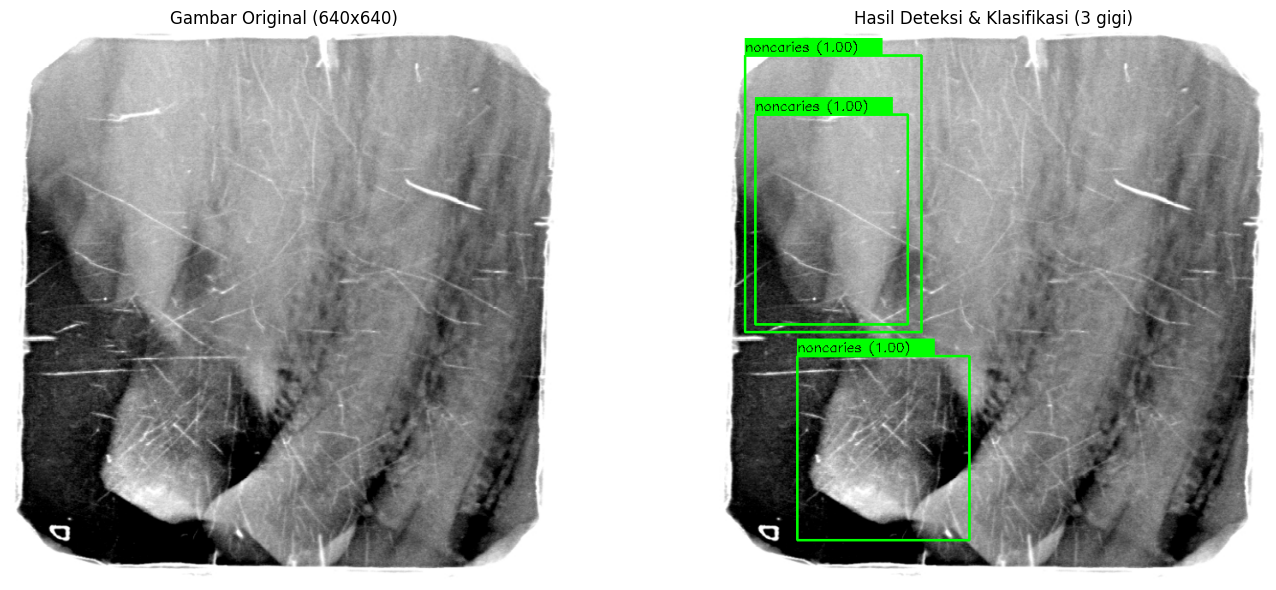

  - Jumlah gigi terdeteksi: 3
  - Gigi #1 - Confidence: 0.47, Klasifikasi: noncaries (1.00)
  - Gigi #2 - Confidence: 0.42, Klasifikasi: noncaries (1.00)
  - Gigi #3 - Confidence: 0.36, Klasifikasi: noncaries (1.00)

Memproses gambar 14/21: Primary Endodontic Lesion (33).JPG
Melakukan resize gambar ke 640x640 pixels...
Mendeteksi gigi...

0: 640x640 5 tooths, 268.6ms
Speed: 3.7ms preprocess, 268.6ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)
Menerapkan CLAHE pada gigi #1...
Melakukan klasifikasi pada gigi #1...

0: 640x640 noncaries 0.62, caries_media 0.38, caries_superficial 0.00, caries_profunda 0.00, 123.4ms
Speed: 19.7ms preprocess, 123.4ms inference, 0.1ms postprocess per image at shape (1, 3, 640, 640)
Menerapkan CLAHE pada gigi #2...
Melakukan klasifikasi pada gigi #2...

0: 640x640 noncaries 0.83, caries_media 0.17, caries_profunda 0.00, caries_superficial 0.00, 142.6ms
Speed: 24.5ms preprocess, 142.6ms inference, 0.1ms postprocess per image at shape (1, 3

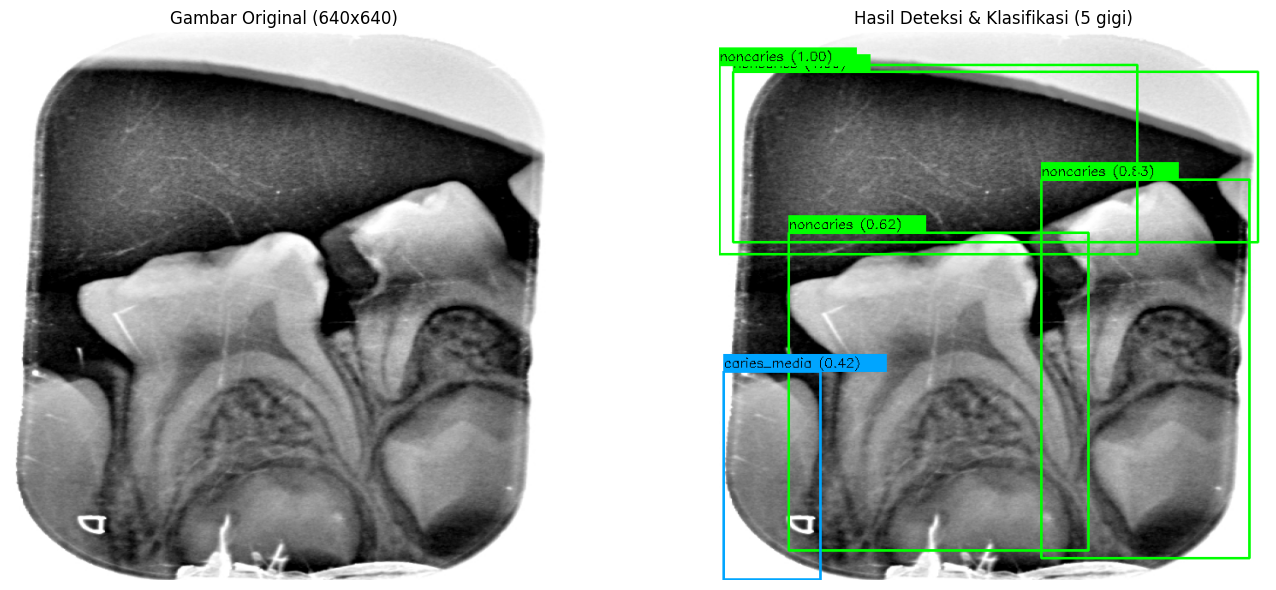

  - Jumlah gigi terdeteksi: 5
  - Gigi #1 - Confidence: 0.84, Klasifikasi: noncaries (0.62)
  - Gigi #2 - Confidence: 0.61, Klasifikasi: noncaries (0.83)
  - Gigi #3 - Confidence: 0.58, Klasifikasi: caries_media (0.42)
  - Gigi #4 - Confidence: 0.45, Klasifikasi: noncaries (1.00)
  - Gigi #5 - Confidence: 0.26, Klasifikasi: noncaries (1.00)

Memproses gambar 15/21: Primary Endodontic Lesion (35).JPG
Melakukan resize gambar ke 640x640 pixels...
Mendeteksi gigi...

0: 640x640 5 tooths, 289.2ms
Speed: 3.6ms preprocess, 289.2ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)
Menerapkan CLAHE pada gigi #1...
Melakukan klasifikasi pada gigi #1...

0: 640x640 caries_media 0.77, noncaries 0.23, caries_profunda 0.01, caries_superficial 0.00, 123.7ms
Speed: 33.9ms preprocess, 123.7ms inference, 0.1ms postprocess per image at shape (1, 3, 640, 640)
Menerapkan CLAHE pada gigi #2...
Melakukan klasifikasi pada gigi #2...

0: 640x640 caries_media 0.98, noncaries 0.01, caries_profunda

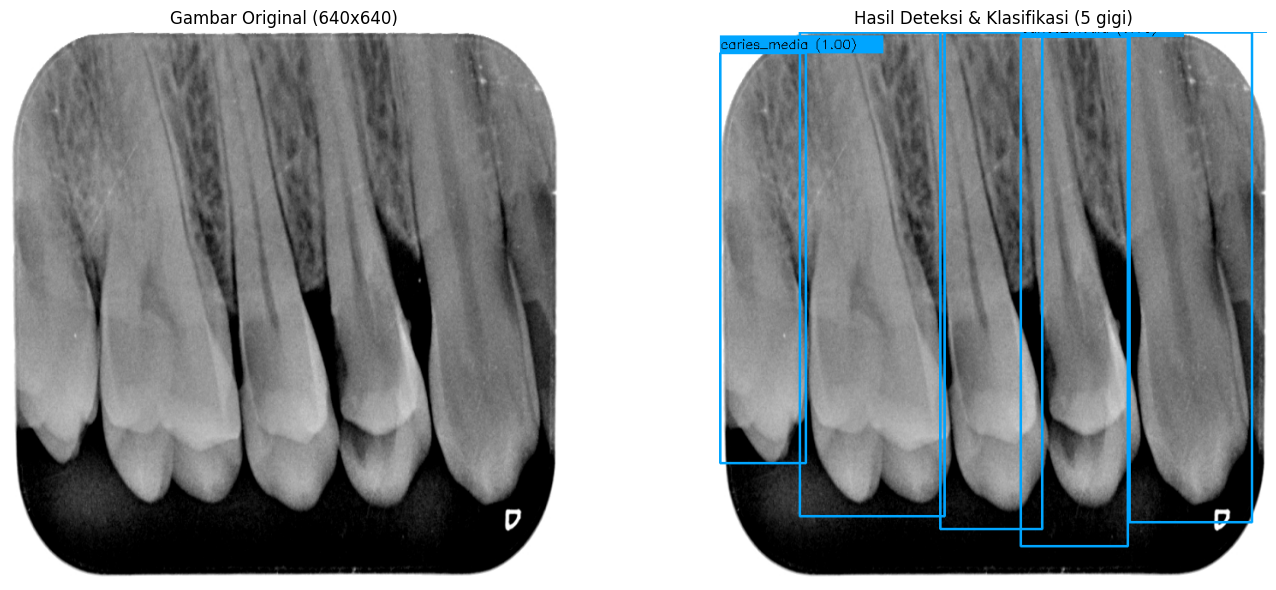

  - Jumlah gigi terdeteksi: 5
  - Gigi #1 - Confidence: 0.77, Klasifikasi: caries_media (0.77)
  - Gigi #2 - Confidence: 0.68, Klasifikasi: caries_media (0.98)
  - Gigi #3 - Confidence: 0.68, Klasifikasi: caries_media (0.98)
  - Gigi #4 - Confidence: 0.40, Klasifikasi: caries_media (0.68)
  - Gigi #5 - Confidence: 0.28, Klasifikasi: caries_media (1.00)

Memproses gambar 16/21: Primary Endodontic Lesion (50).JPG
Melakukan resize gambar ke 640x640 pixels...
Mendeteksi gigi...

0: 640x640 2 tooths, 289.8ms
Speed: 3.8ms preprocess, 289.8ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)
Menerapkan CLAHE pada gigi #1...
Melakukan klasifikasi pada gigi #1...

0: 640x640 noncaries 1.00, caries_superficial 0.00, caries_profunda 0.00, caries_media 0.00, 125.0ms
Speed: 18.6ms preprocess, 125.0ms inference, 0.1ms postprocess per image at shape (1, 3, 640, 640)
Menerapkan CLAHE pada gigi #2...
Melakukan klasifikasi pada gigi #2...

0: 640x640 caries_media 0.98, noncaries 0.02, car

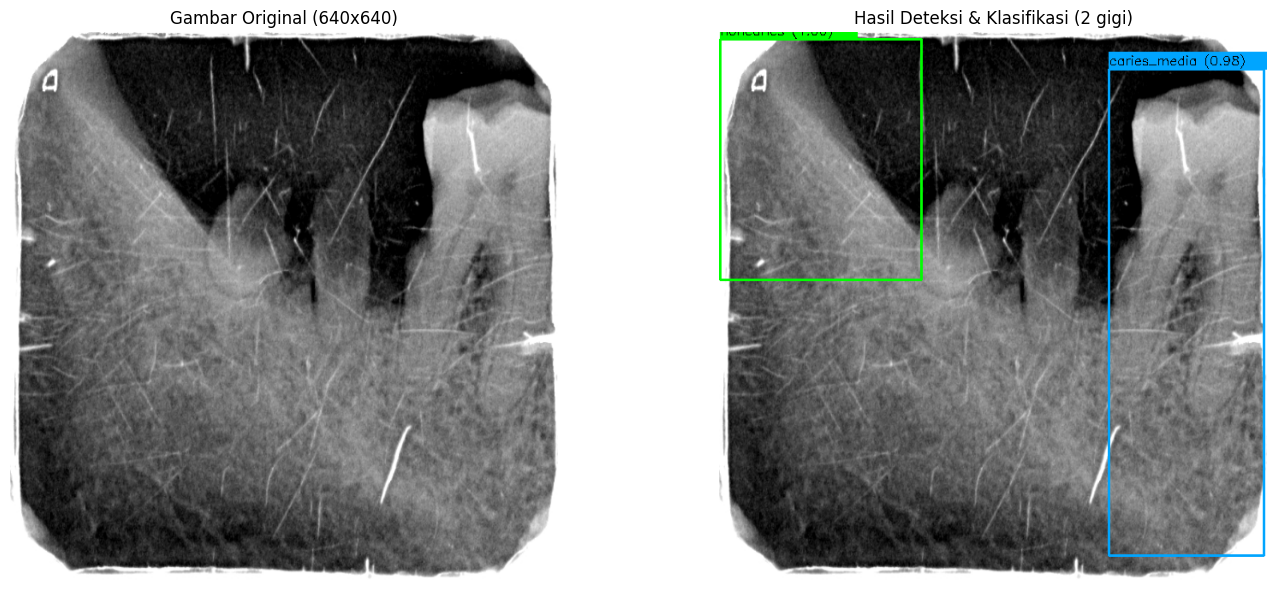

  - Jumlah gigi terdeteksi: 2
  - Gigi #1 - Confidence: 0.59, Klasifikasi: noncaries (1.00)
  - Gigi #2 - Confidence: 0.51, Klasifikasi: caries_media (0.98)

Memproses gambar 17/21: Primary Endodontic Lesion (52).JPG
Melakukan resize gambar ke 640x640 pixels...
Mendeteksi gigi...

0: 640x640 6 tooths, 296.5ms
Speed: 3.7ms preprocess, 296.5ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)
Menerapkan CLAHE pada gigi #1...
Melakukan klasifikasi pada gigi #1...

0: 640x640 noncaries 1.00, caries_media 0.00, caries_profunda 0.00, caries_superficial 0.00, 121.9ms
Speed: 22.5ms preprocess, 121.9ms inference, 0.1ms postprocess per image at shape (1, 3, 640, 640)
Menerapkan CLAHE pada gigi #2...
Melakukan klasifikasi pada gigi #2...

0: 640x640 noncaries 1.00, caries_profunda 0.00, caries_superficial 0.00, caries_media 0.00, 126.8ms
Speed: 32.0ms preprocess, 126.8ms inference, 0.1ms postprocess per image at shape (1, 3, 640, 640)
Menerapkan CLAHE pada gigi #3...
Melakukan klas

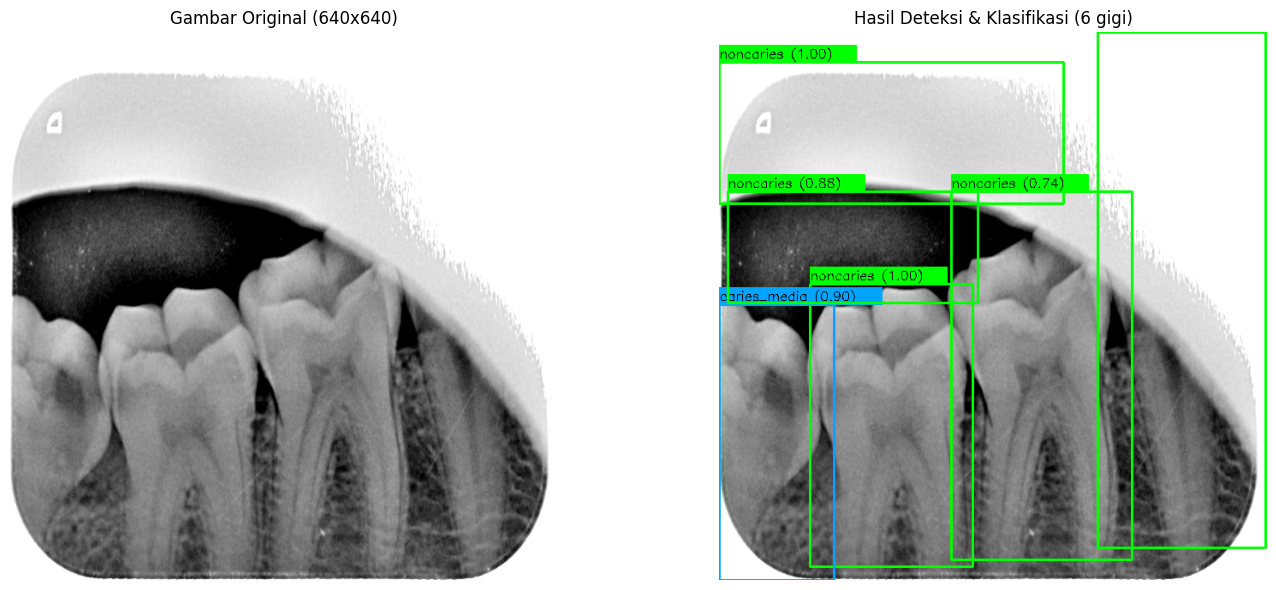

  - Jumlah gigi terdeteksi: 6
  - Gigi #1 - Confidence: 0.81, Klasifikasi: noncaries (1.00)
  - Gigi #2 - Confidence: 0.69, Klasifikasi: noncaries (1.00)
  - Gigi #3 - Confidence: 0.60, Klasifikasi: caries_media (0.90)
  - Gigi #4 - Confidence: 0.60, Klasifikasi: noncaries (1.00)
  - Gigi #5 - Confidence: 0.55, Klasifikasi: noncaries (0.88)
  - Gigi #6 - Confidence: 0.52, Klasifikasi: noncaries (0.74)

Memproses gambar 18/21: Primary Perio with Secondary Endo (31).JPG
Melakukan resize gambar ke 640x640 pixels...
Mendeteksi gigi...

0: 640x640 4 tooths, 264.9ms
Speed: 3.8ms preprocess, 264.9ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)
Menerapkan CLAHE pada gigi #1...
Melakukan klasifikasi pada gigi #1...

0: 640x640 caries_media 0.85, caries_profunda 0.08, noncaries 0.07, caries_superficial 0.00, 130.4ms
Speed: 24.9ms preprocess, 130.4ms inference, 0.1ms postprocess per image at shape (1, 3, 640, 640)
Menerapkan CLAHE pada gigi #2...
Melakukan klasifikasi pada gig

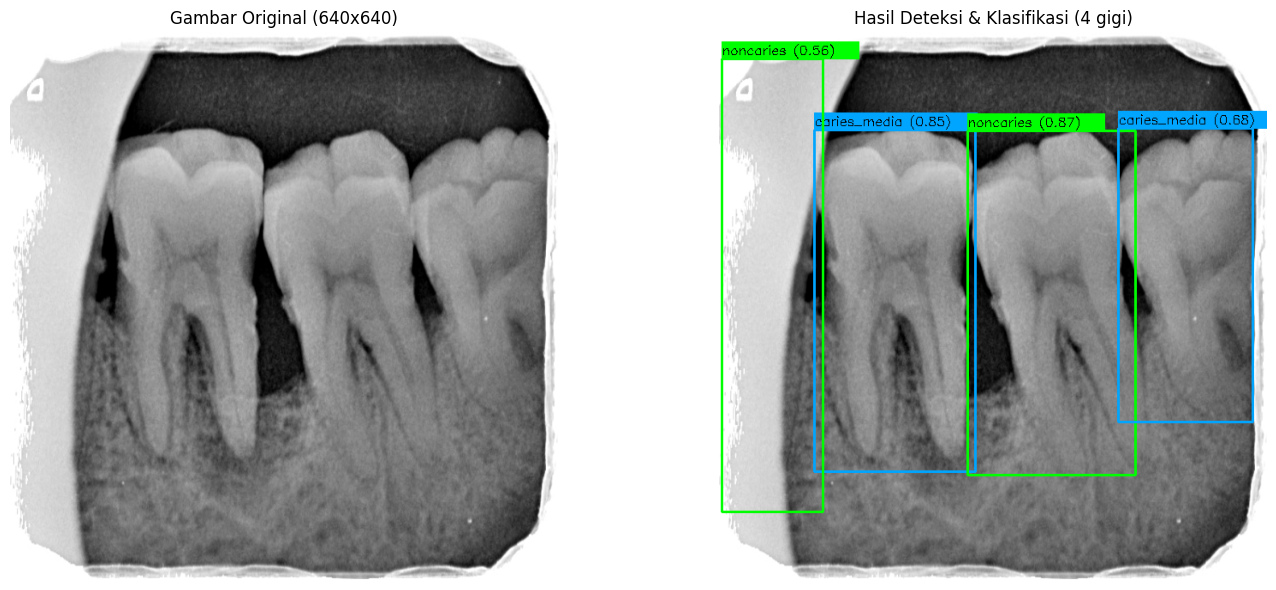

  - Jumlah gigi terdeteksi: 4
  - Gigi #1 - Confidence: 0.84, Klasifikasi: caries_media (0.85)
  - Gigi #2 - Confidence: 0.83, Klasifikasi: noncaries (0.87)
  - Gigi #3 - Confidence: 0.71, Klasifikasi: caries_media (0.68)
  - Gigi #4 - Confidence: 0.39, Klasifikasi: noncaries (0.56)

Memproses gambar 19/21: Primary Perio with Secondary Endo (33).JPG
Melakukan resize gambar ke 640x640 pixels...
Mendeteksi gigi...

0: 640x640 4 tooths, 314.9ms
Speed: 4.1ms preprocess, 314.9ms inference, 3.9ms postprocess per image at shape (1, 3, 640, 640)
Menerapkan CLAHE pada gigi #1...
Melakukan klasifikasi pada gigi #1...

0: 640x640 noncaries 0.86, caries_profunda 0.08, caries_superficial 0.06, caries_media 0.00, 133.7ms
Speed: 21.8ms preprocess, 133.7ms inference, 0.1ms postprocess per image at shape (1, 3, 640, 640)
Menerapkan CLAHE pada gigi #2...
Melakukan klasifikasi pada gigi #2...

0: 640x640 caries_media 0.98, noncaries 0.02, caries_profunda 0.01, caries_superficial 0.00, 164.0ms
Speed: 40.4

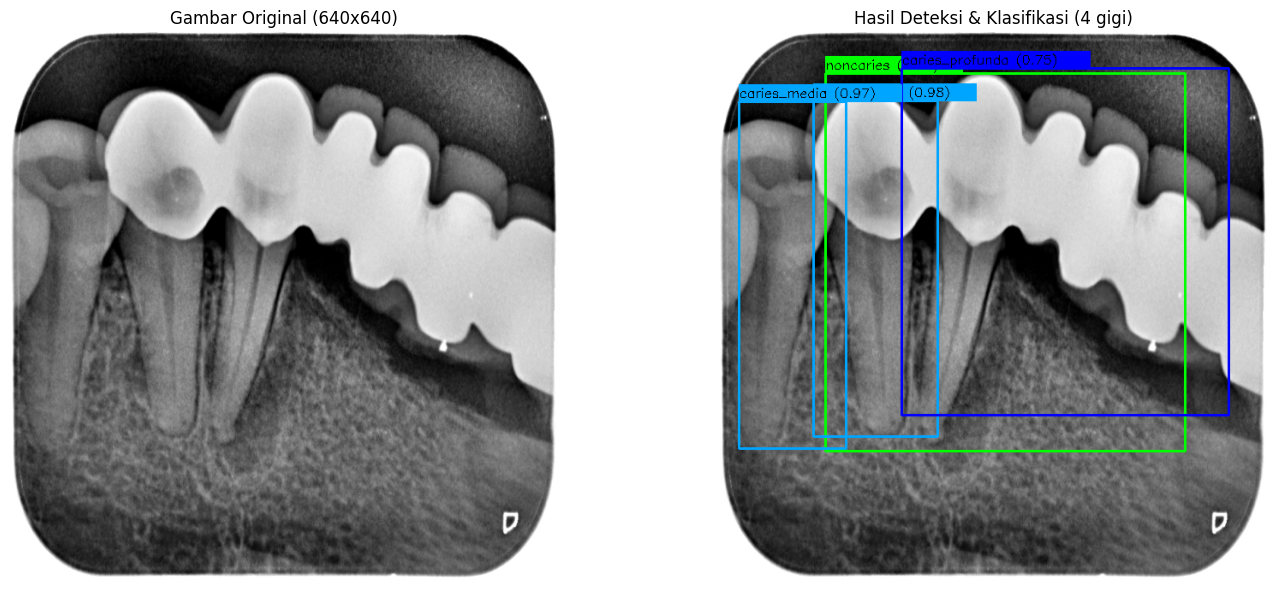

  - Jumlah gigi terdeteksi: 4
  - Gigi #1 - Confidence: 0.47, Klasifikasi: noncaries (0.86)
  - Gigi #2 - Confidence: 0.34, Klasifikasi: caries_media (0.98)
  - Gigi #3 - Confidence: 0.28, Klasifikasi: caries_profunda (0.75)
  - Gigi #4 - Confidence: 0.26, Klasifikasi: caries_media (0.97)

Memproses gambar 20/21: Primary Periodontal Lesion (6).JPG
Melakukan resize gambar ke 640x640 pixels...
Mendeteksi gigi...

0: 640x640 5 tooths, 278.5ms
Speed: 3.9ms preprocess, 278.5ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)
Menerapkan CLAHE pada gigi #1...
Melakukan klasifikasi pada gigi #1...

0: 640x640 noncaries 1.00, caries_media 0.00, caries_profunda 0.00, caries_superficial 0.00, 138.6ms
Speed: 31.8ms preprocess, 138.6ms inference, 0.1ms postprocess per image at shape (1, 3, 640, 640)
Menerapkan CLAHE pada gigi #2...
Melakukan klasifikasi pada gigi #2...

0: 640x640 caries_media 0.99, noncaries 0.01, caries_profunda 0.00, caries_superficial 0.00, 127.3ms
Speed: 41.1ms

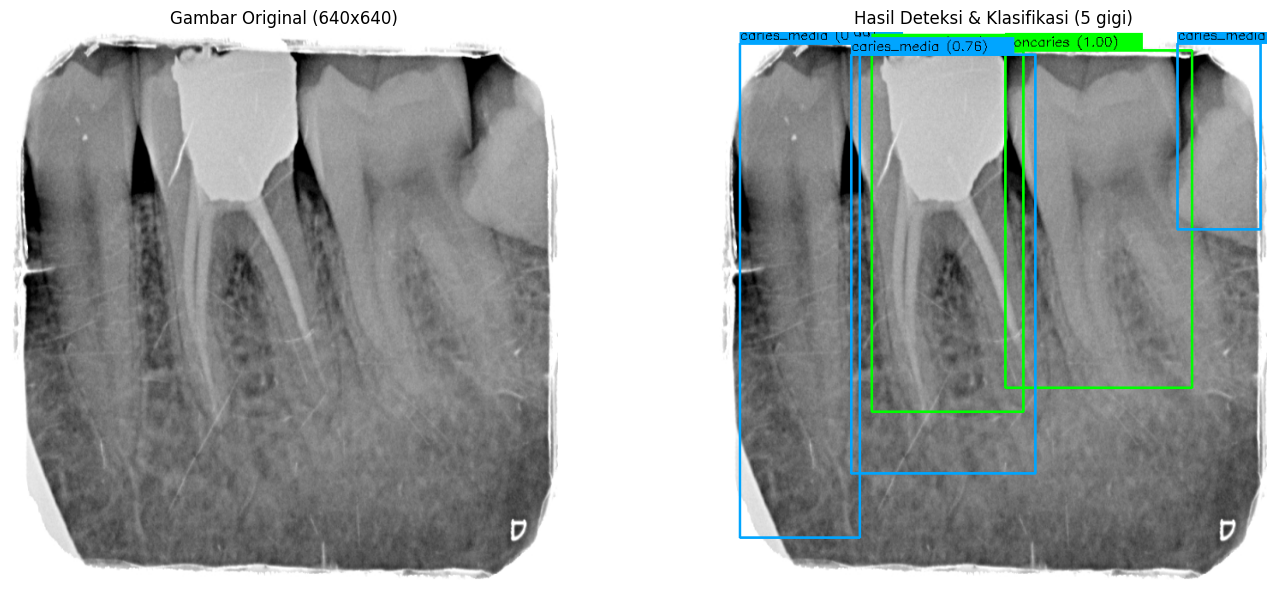

  - Jumlah gigi terdeteksi: 5
  - Gigi #1 - Confidence: 0.77, Klasifikasi: noncaries (1.00)
  - Gigi #2 - Confidence: 0.62, Klasifikasi: caries_media (0.99)
  - Gigi #3 - Confidence: 0.51, Klasifikasi: caries_media (0.81)
  - Gigi #4 - Confidence: 0.48, Klasifikasi: noncaries (0.65)
  - Gigi #5 - Confidence: 0.35, Klasifikasi: caries_media (0.76)

Memproses gambar 21/21: Primary Periodontal Lesion (8).JPG
Melakukan resize gambar ke 640x640 pixels...
Mendeteksi gigi...

0: 640x640 6 tooths, 321.9ms
Speed: 3.7ms preprocess, 321.9ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)
Menerapkan CLAHE pada gigi #1...
Melakukan klasifikasi pada gigi #1...

0: 640x640 noncaries 1.00, caries_superficial 0.00, caries_media 0.00, caries_profunda 0.00, 171.6ms
Speed: 42.6ms preprocess, 171.6ms inference, 0.1ms postprocess per image at shape (1, 3, 640, 640)
Menerapkan CLAHE pada gigi #2...
Melakukan klasifikasi pada gigi #2...

0: 640x640 noncaries 0.99, caries_media 0.01, caries_pr

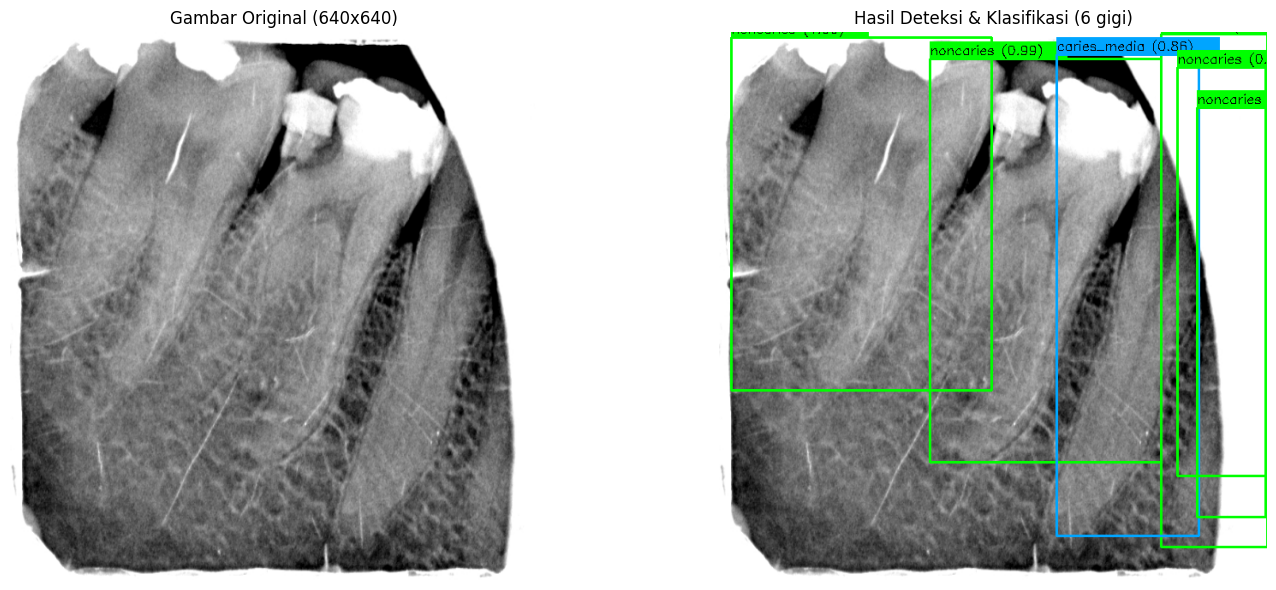

  - Jumlah gigi terdeteksi: 6
  - Gigi #1 - Confidence: 0.71, Klasifikasi: noncaries (1.00)
  - Gigi #2 - Confidence: 0.64, Klasifikasi: noncaries (0.99)
  - Gigi #3 - Confidence: 0.42, Klasifikasi: noncaries (0.98)
  - Gigi #4 - Confidence: 0.35, Klasifikasi: caries_media (0.86)
  - Gigi #5 - Confidence: 0.28, Klasifikasi: noncaries (0.98)
  - Gigi #6 - Confidence: 0.26, Klasifikasi: noncaries (0.97)

=== RINGKASAN HASIL ===
Total gambar yang diproses: 21
Total gigi terdeteksi: 85
Distribusi klasifikasi:
  - noncaries: 47 (55.3%)
  - caries_media: 35 (41.2%)
  - caries_profunda: 3 (3.5%)


In [11]:
print("OPSI 1: Upload gambar test secara langsung")
print("Silakan upload gambar test (bisa multiple files):")
try:
    uploaded = files.upload()

    # Simpan gambar yang diupload ke folder test
    image_paths = []
    for filename, content in uploaded.items():
        save_path = os.path.join(test_folder, filename)
        with open(save_path, 'wb') as f:
            f.write(content)
        image_paths.append(save_path)
    print(f"Berhasil menyimpan {len(uploaded)} gambar ke folder test")

    # Jalankan proses pengujian
    if image_paths:
        conf_threshold = 0.25  # Threshold confidence untuk deteksi
        print("\nMemulai proses pengujian pada gambar yang diupload...")
        process_test_images(image_paths, detector, classifier, conf_threshold)
    else:
        print("Tidak ada gambar yang diupload.")
except Exception as e:
    print(f"Error saat upload: {e}")
    print("Mencoba opsi alternatif...")